<a href="https://colab.research.google.com/github/junlongchen0829/Protein-Signal-Peptide-Classification-LB2/blob/main/LB2_Final_Project_Full_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import pandas as pd
import io
import time
import os  # <--- 新增：用于处理文件路径

def fetch_uniprot_data(query, output_filename):
    """
    从 UniProtKB 抓取数据并保存为 TSV。
    会自动创建 data/raw 文件夹。
    """
    # 1. 定义保存路径 (自动创建文件夹)
    output_dir = "data/raw"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"📁 已自动创建文件夹: {output_dir}")

    save_path = os.path.join(output_dir, output_filename)

    # 2. UniProt API 设置
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    # 我们需要的列：ID, 序列, 长度, 信号肽标注, 跨膜标注, 亚细胞定位, 生物名称
    fields = "accession,sequence,length,ft_signal,ft_transmem,cc_subcellular_location,organism_name"

    params = {
        "query": query,
        "format": "tsv",
        "fields": fields,
        "size": 500
    }

    print(f"🚀 开始抓取: {output_filename} ...")
    all_data = []

    try:
        # 第一次请求
        response = requests.get(base_url, params=params)
        response.raise_for_status()

        # 循环翻页
        while True:
            # 读取当前页数据
            batch_df = pd.read_csv(io.StringIO(response.text), sep='\t')
            all_data.append(batch_df)
            print(f"   已获取 {len(batch_df)} 条数据...", end='\r')

            # 检查下一页
            if "next" in response.links:
                next_url = response.links["next"]["url"]
                response = requests.get(next_url)
            else:
                break

        # 合并数据
        if all_data:
            final_df = pd.concat(all_data, ignore_index=True)
            # 保存文件
            final_df.to_csv(save_path, sep='\t', index=False)
            print(f"\n✅ 成功! 共 {len(final_df)} 条数据已保存至: {save_path}\n")
        else:
            print(f"\n⚠️ 未找到任何数据: {output_filename}\n")

    except Exception as e:
        print(f"\n❌ 发生错误: {e}")

# ================= 定义查询逻辑 =================

# 1. 正样本 (Positive): 真核 + Swiss-Prot + 实验验证的信号肽 + 非片段
query_positive = '(taxonomy_id:2759) AND (reviewed:true) AND (fragment:false) AND (ft_signal_exp:*)'

# 2. 负样本 - 细胞内 (Negative Cyto/Nuc): 真核 + Swiss-Prot + 无信号肽 + (细胞质 OR 细胞核)
query_neg_cyto = '(taxonomy_id:2759) AND (reviewed:true) AND (fragment:false) AND NOT (ft_signal:*) AND ((cc_scl_term:SL-0086) OR (cc_scl_term:SL-0191))'

# 3. 负样本 - 跨膜蛋白 (Negative TM): 真核 + Swiss-Prot + 无信号肽 + 实验验证的跨膜区
# 注意：这里我们加入 keyword:KW-0812 (Transmembrane) 以放宽一点限制，确保能抓到数据
query_neg_tm = '(taxonomy_id:2759) AND (reviewed:true) AND (fragment:false) AND NOT (ft_signal:*) AND (keyword:KW-0812)'

if __name__ == "__main__":
    # 执行抓取
    fetch_uniprot_data(query_positive, "positive_set.tsv")
    fetch_uniprot_data(query_neg_cyto, "negative_cyto.tsv")
    fetch_uniprot_data(query_neg_tm, "negative_tm.tsv")

📁 已自动创建文件夹: data/raw
🚀 开始抓取: positive_set.tsv ...
   已获取 468 条数据...
✅ 成功! 共 2968 条数据已保存至: data/raw/positive_set.tsv

🚀 开始抓取: negative_cyto.tsv ...

✅ 成功! 共 66184 条数据已保存至: data/raw/negative_cyto.tsv

🚀 开始抓取: negative_tm.tsv ...

✅ 成功! 共 36883 条数据已保存至: data/raw/negative_tm.tsv



In [4]:
# ==========================================
# 步骤 1: 确保 mmseqs2 已安装
# ==========================================
import os
import subprocess
import pandas as pd
from sklearn.model_selection import train_test_split

# 检查是否安装
if not os.path.exists("mmseqs/bin/mmseqs"):
    print("⚙️ 正在安装 mmseqs2...")
    !mkdir -p mmseqs
    !wget -q https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz -O mmseqs.tar.gz
    !tar xzf mmseqs.tar.gz -C mmseqs
    print("✅ mmseqs2 安装完成！")

MMSEQS = "./mmseqs/mmseqs/bin/mmseqs"

# ==========================================
# 步骤 2: 定义智能处理函数 (已修复 KeyError)
# ==========================================
def run_mmseqs_clustering(input_tsv, output_prefix, min_seq_id=0.3, coverage=0.4):
    print(f"\n🚀 处理中: {input_tsv} ...")

    # A. 读取 TSV
    try:
        df = pd.read_csv(input_tsv, sep='\t')
    except FileNotFoundError:
        print(f"❌ 文件未找到: {input_tsv}，请检查上一步是否成功下载。")
        return pd.DataFrame()

    original_count = len(df)

    # --- 自动检测列名 ---
    # 找 ID 列
    id_col = None
    for candidate in ['Entry', 'accession', 'Accession', 'id', 'ID']:
        if candidate in df.columns:
            id_col = candidate
            break

    # 找 序列 列
    seq_col = None
    for candidate in ['Sequence', 'sequence', 'seq']:
        if candidate in df.columns:
            seq_col = candidate
            break

    if not id_col or not seq_col:
        print(f"❌ 无法识别列名! 现有列名: {df.columns.tolist()}")
        return pd.DataFrame()

    print(f"   (识别到 ID列: '{id_col}', 序列列: '{seq_col}')")

    # B. 转换为 FASTA
    fasta_path = f"{output_prefix}.fasta"
    with open(fasta_path, 'w') as f:
        for idx, row in df.iterrows():
            # 确保序列不为空
            if pd.notna(row[seq_col]):
                f.write(f">{row[id_col]}\n{row[seq_col]}\n")

    # C. 运行 mmseqs
    # --min-seq-id 0.3 (30% 相似度), -c 0.4 (40% 覆盖度)
    cmd = f"{MMSEQS} easy-cluster {fasta_path} {output_prefix}_cluster tmp --min-seq-id {min_seq_id} -c {coverage} --cov-mode 1 > /dev/null"
    subprocess.run(cmd, shell=True, check=True)

    # D. 读取代表序列
    rep_fasta = f"{output_prefix}_cluster_rep_seq.fasta"
    kept_ids = []

    if os.path.exists(rep_fasta):
        with open(rep_fasta, 'r') as f:
            for line in f:
                if line.startswith(">"):
                    kept_ids.append(line.strip()[1:])
    else:
        print("⚠️ mmseqs 未生成结果文件，可能输入为空。")
        return pd.DataFrame()

    # E. 过滤 DataFrame
    df_clean = df[df[id_col].isin(kept_ids)].copy()

    # 统一列名为标准名称，方便后续使用
    df_clean = df_clean.rename(columns={id_col: 'accession', seq_col: 'sequence'})

    print(f"   原始数量: {original_count}")
    print(f"   去冗余后: {len(df_clean)}")
    print(f"   保留率: {len(df_clean)/original_count:.1%}")

    return df_clean

# ==========================================
# 步骤 3: 执行流水线
# ==========================================
!mkdir -p data/processed

# 1. 正样本
df_pos = run_mmseqs_clustering("data/raw/positive_set.tsv", "data/processed/pos")
df_pos['label'] = 1

# 2. 负样本 (Cyto)
df_neg_cyto = run_mmseqs_clustering("data/raw/negative_cyto.tsv", "data/processed/neg_cyto")
df_neg_cyto['label'] = 0

# 3. 负样本 (TM - Hard Negatives)
df_neg_tm = run_mmseqs_clustering("data/raw/negative_tm.tsv", "data/processed/neg_tm")
df_neg_tm['label'] = 0

# ==========================================
# 步骤 4: 平衡与划分
# ==========================================
print("\n⚖️ 正在构建数据集...")

if not df_pos.empty:
    n_pos = len(df_pos)
    # 负样本采样：设为正样本的 2 倍
    target_neg = n_pos * 2
    target_half = target_neg // 2

    # 采样
    df_cyto_sample = df_neg_cyto.sample(n=min(len(df_neg_cyto), target_half), random_state=42)
    df_tm_sample = df_neg_tm.sample(n=min(len(df_neg_tm), target_half), random_state=42)

    # 合并
    df_final = pd.concat([df_pos, df_cyto_sample, df_tm_sample], ignore_index=True)

    # 划分 Train/Test (80/20)
    train, test = train_test_split(df_final, test_size=0.2, random_state=42, stratify=df_final['label'])

    # 保存
    train.to_csv("data/processed/train_set.csv", index=False)
    test.to_csv("data/processed/test_set.csv", index=False)

    print("\n" + "="*40)
    print(f"🎉 成功！最终数据集: {len(df_final)} 条")
    print(f"训练集: {len(train)} | 测试集: {len(test)}")
    print("文件已保存至 data/processed/ 目录")
else:
    print("❌ 正样本为空，请检查数据下载步骤。")

⚙️ 正在安装 mmseqs2...
✅ mmseqs2 安装完成！

🚀 处理中: data/raw/positive_set.tsv ...
   (识别到 ID列: 'Entry', 序列列: 'Sequence')
   原始数量: 2968
   去冗余后: 1096
   保留率: 36.9%

🚀 处理中: data/raw/negative_cyto.tsv ...
   (识别到 ID列: 'Entry', 序列列: 'Sequence')
   原始数量: 66184
   去冗余后: 11673
   保留率: 17.6%

🚀 处理中: data/raw/negative_tm.tsv ...
   (识别到 ID列: 'Entry', 序列列: 'Sequence')
   原始数量: 36883
   去冗余后: 5243
   保留率: 14.2%

⚖️ 正在构建数据集...

🎉 成功！最终数据集: 3288 条
训练集: 2630 | 测试集: 658
文件已保存至 data/processed/ 目录


/tmp/ipython-input-2509826768.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette='viridis')


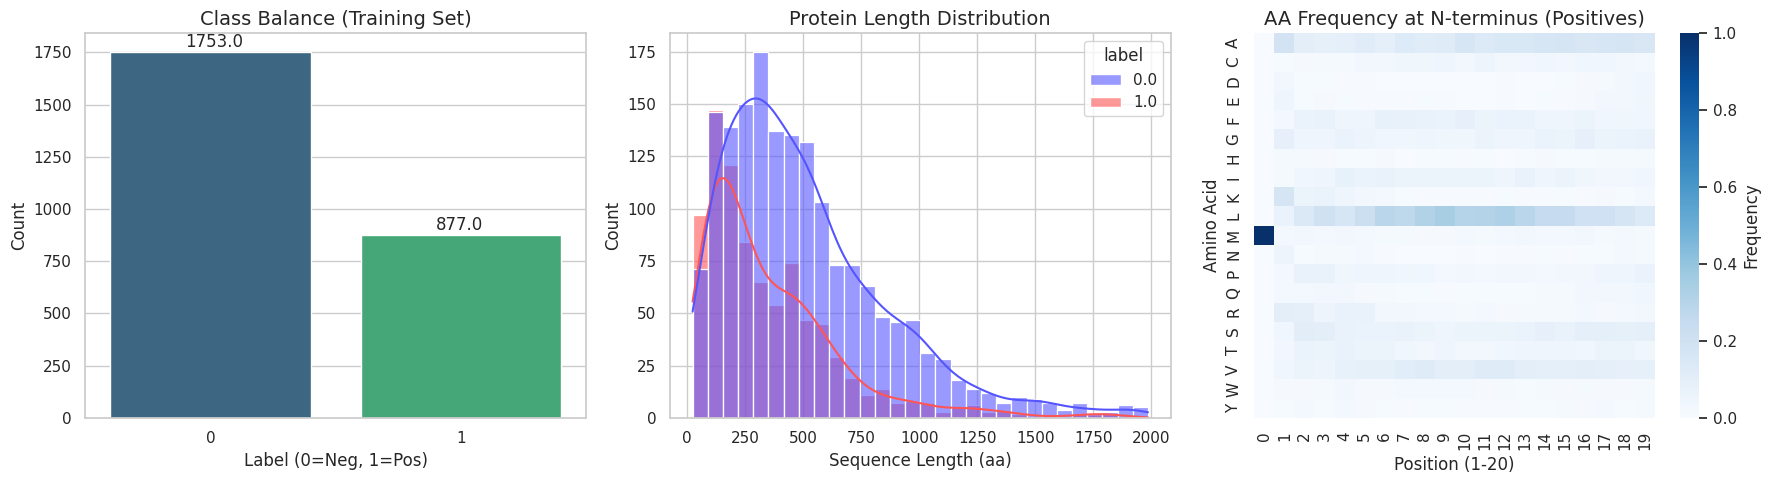

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 读取训练集
df = pd.read_csv("data/processed/train_set.csv")

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 5))

# ==========================================
# 图 1: 类别分布 (Class Distribution)
# ==========================================
plt.subplot(1, 3, 1)
ax = sns.countplot(x='label', data=df, palette='viridis')
plt.title('Class Balance (Training Set)', fontsize=14)
plt.xlabel('Label (0=Neg, 1=Pos)')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 20))

# ==========================================
# 图 2: 序列长度分布 (Sequence Length)
# ==========================================
plt.subplot(1, 3, 2)
# 为了更好看，我们过滤掉超长序列 (>2000 aa)
sns.histplot(data=df[df['sequence'].str.len() < 2000], x=df['sequence'].str.len(),
             hue='label', bins=30, kde=True, palette='seismic', alpha=0.6)
plt.title('Protein Length Distribution', fontsize=14)
plt.xlabel('Sequence Length (aa)')

# ==========================================
# 图 3: N 端氨基酸偏好热图 (N-terminal Heatmap)
# ==========================================
# 这是生物信息学最关键的图：展示 N 端前 20 个氨基酸的规律
plt.subplot(1, 3, 3)

def get_position_counts(sequences, length=20):
    # 统计每个位置上每种氨基酸的出现频率
    aa_list = sorted("ACDEFGHIKLMNPQRSTVWY") # 20种标准氨基酸
    counts = np.zeros((len(aa_list), length))

    for seq in sequences:
        # 只取前 length 个氨基酸，不够的跳过
        if len(seq) < length: continue
        for i in range(length):
            aa = seq[i]
            if aa in aa_list:
                row = aa_list.index(aa)
                counts[row, i] += 1

    # 归一化 (转为概率)
    freqs = counts / counts.sum(axis=0)
    return freqs, aa_list

# 只取正样本 (Signal Peptide) 来分析
pos_seqs = df[df['label'] == 1]['sequence'].tolist()
freqs, aa_labels = get_position_counts(pos_seqs, length=20)

sns.heatmap(freqs, yticklabels=aa_labels, cmap="Blues", cbar_kws={'label': 'Frequency'})
plt.title('AA Frequency at N-terminus (Positives)', fontsize=14)
plt.xlabel('Position (1-20)')
plt.ylabel('Amino Acid')

plt.tight_layout()
plt.show()

📄 Loading data/processed/train_set.csv ...
   ✅ Found signal column: 'Signal peptide' -> Renaming to 'ft_signal'
📄 Loading data/processed/test_set.csv ...
   ✅ Found signal column: 'Signal peptide' -> Renaming to 'ft_signal'

⚙️ 正在构建 PSSM 矩阵...
   使用了 874 条序列构建矩阵 (Total Positives: 877)
🚀 正在测试集上进行预测...

🏆 von Heijne Baseline Model Results
ROC AUC:  0.9142
Best MCC: 0.6898
----------------------------------------


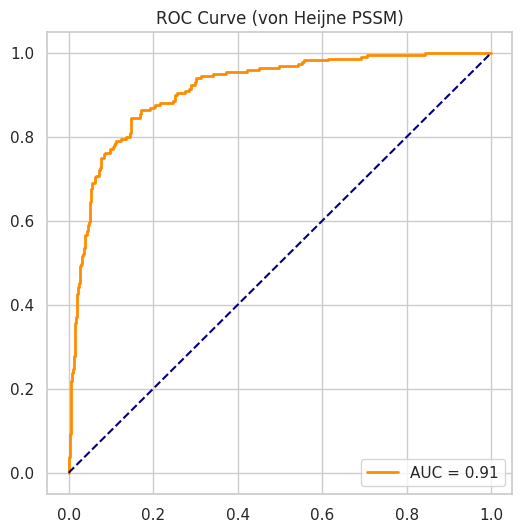

In [9]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef
import seaborn as sns

# ==========================================
# 0. 数据加载与自动修复列名 (核心修复)
# ==========================================
def load_and_fix_data(filepath):
    df = pd.read_csv(filepath)
    print(f"📄 Loading {filepath} ...")

    # 自动查找包含 'Signal' 的列名
    signal_col = None
    for col in df.columns:
        if 'Signal' in col or 'signal' in col:
            signal_col = col
            break

    if signal_col:
        print(f"   ✅ Found signal column: '{signal_col}' -> Renaming to 'ft_signal'")
        df = df.rename(columns={signal_col: 'ft_signal'})
    else:
        print(f"   ⚠️ Warning: No 'Signal' column found in {df.columns.tolist()}")
        # 如果找不到，创建一个空的以便后续不报错（仅限负样本可能发生）
        if 'ft_signal' not in df.columns:
            df['ft_signal'] = np.nan

    return df

# 加载数据
train_df = load_and_fix_data("data/processed/train_set.csv")
test_df = load_and_fix_data("data/processed/test_set.csv")

# ==========================================
# 1. 辅助函数：解析切割位点
# ==========================================
def get_cleavage_site(ft_signal_str):
    """
    解析 "SIGNAL 1..23; ..." -> 返回 23
    """
    if pd.isna(ft_signal_str): return None
    # 匹配 "SIGNAL 1..23" 或 "Signal peptide 1..23"
    match = re.search(r"(?:SIGNAL|Signal peptide)\s+1\.\.(\d+)", str(ft_signal_str))
    if match:
        return int(match.group(1))
    return None

# ==========================================
# 2. 训练：构建 PSSM 矩阵
# ==========================================
def train_pswm(train_df, window_upstream=13, window_downstream=2):
    print("\n⚙️ 正在构建 PSSM 矩阵...")

    # 初始化: 20种氨基酸
    aa_order = sorted("ACDEFGHIKLMNPQRSTVWY")
    window_len = window_upstream + window_downstream
    counts = np.zeros((20, window_len))

    valid_count = 0

    # 只使用正样本 (Label=1)
    pos_df = train_df[train_df['label'] == 1]

    for _, row in pos_df.iterrows():
        # 获取切点位置
        cut_pos = get_cleavage_site(row.get('ft_signal'))
        seq = row['sequence']

        # 确保切点存在且序列足够长
        if cut_pos and len(seq) > cut_pos + window_downstream:
            # 提取窗口序列 [-13, +2]
            start_idx = cut_pos - window_upstream
            end_idx = cut_pos + window_downstream

            if start_idx >= 0:
                sub_seq = seq[start_idx : end_idx]

                # 统计氨基酸频次
                for i, aa in enumerate(sub_seq):
                    if aa in aa_order:
                        row_idx = aa_order.index(aa)
                        counts[row_idx, i] += 1
                valid_count += 1

    print(f"   使用了 {valid_count} 条序列构建矩阵 (Total Positives: {len(pos_df)})")

    # 计算对数几率 (Log-Odds)
    counts += 1 # 伪计数
    probs = counts / counts.sum(axis=0)
    bg_prob = 1/20
    pswm = np.log2(probs / bg_prob)

    return pswm, aa_order

# ==========================================
# 3. 预测与评估
# ==========================================
def scan_sequence(seq, pswm, aa_order, window_upstream=13, window_downstream=2):
    window_len = window_upstream + window_downstream
    max_score = -999.0
    # 扫描前 60 个氨基酸
    scan_limit = min(len(seq) - window_len, 60)

    if scan_limit <= 0: return -999.0

    for i in range(scan_limit):
        sub_seq = seq[i : i+window_len]
        current_score = 0.0
        for j, aa in enumerate(sub_seq):
            if aa in aa_order:
                current_score += pswm[aa_order.index(aa), j]
        if current_score > max_score:
            max_score = current_score
    return max_score

# --- 执行 ---
# 1. 训练
pswm_matrix, aa_list = train_pswm(train_df)

# 2. 预测
print("🚀 正在测试集上进行预测...")
test_scores = []
for seq in test_df['sequence']:
    test_scores.append(scan_sequence(seq, pswm_matrix, aa_list))

test_df['pred_score'] = test_scores

# 3. 评估结果
fpr, tpr, thresholds = roc_curve(test_df['label'], test_df['pred_score'])
roc_auc = auc(fpr, tpr)

# 寻找最佳 MCC
best_mcc = -1
best_thresh = 0
# 快速寻找最佳阈值
for thresh in np.percentile(test_scores, np.arange(0, 100, 1)):
    y_pred = [1 if s >= thresh else 0 for s in test_scores]
    mcc = matthews_corrcoef(test_df['label'], y_pred)
    if mcc > best_mcc:
        best_mcc = mcc
        best_thresh = thresh

print("\n" + "="*40)
print(f"🏆 von Heijne Baseline Model Results")
print("="*40)
print(f"ROC AUC:  {roc_auc:.4f}")
print(f"Best MCC: {best_mcc:.4f}")
print("-" * 40)

# 4. 画图
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve (von Heijne PSSM)')
plt.legend(loc="lower right")
plt.show()

⚙️ 正在提取特征 (2630 条序列)...
⚙️ 正在提取特征 (658 条序列)...
   特征矩阵形状: (2630, 21)

🚀 正在训练 SVM (RBF Kernel)...
✅ 训练完成！

🏆 SVM Model Results
Accuracy: 0.8587
ROC AUC:  0.9366
MCC:      0.6853
----------------------------------------

Detailed Report:

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89       439
    Positive       0.78      0.81      0.79       219

    accuracy                           0.86       658
   macro avg       0.84      0.85      0.84       658
weighted avg       0.86      0.86      0.86       658



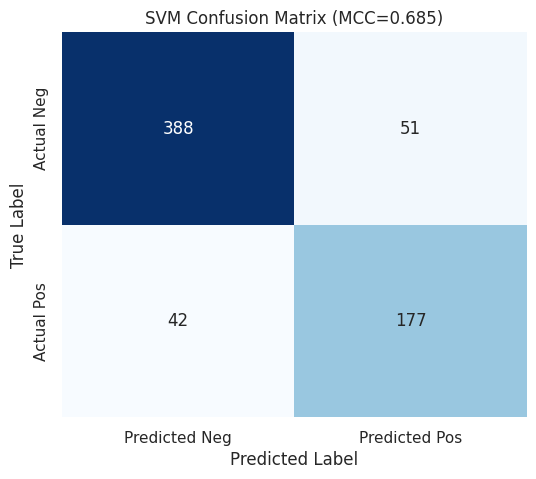

In [10]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 特征提取函数 (Feature Engineering)
# ==========================================
# 标准氨基酸列表
AA_LIST = sorted("ACDEFGHIKLMNPQRSTVWY")
# Kyte-Doolittle 疏水性量表
HYDRO_SCALE = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8, 'G': -0.4, 'H': -3.2,
    'I': 4.5, 'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5,
    'R': -4.5, 'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

def extract_features(sequence, n_term_len=30):
    """
    提取两个核心特征：
    1. AAC (20维): N端前30个氨基酸的组分
    2. Avg Hydrophobicity (1维): N端的平均疏水性
    总共 21 维特征。
    """
    # 截取 N 端 (信号肽通常在前 30 aa)
    seq_fragment = sequence[:n_term_len]
    length = len(seq_fragment)

    if length == 0: return np.zeros(21)

    # 1. 计算 AAC (20 维)
    # 统计每个氨基酸出现的次数 / 总长度
    aac_features = []
    for aa in AA_LIST:
        count = seq_fragment.count(aa)
        aac_features.append(count / length)

    # 2. 计算平均疏水性 (1 维)
    hydro_score = 0
    valid_aa = 0
    for aa in seq_fragment:
        if aa in HYDRO_SCALE:
            hydro_score += HYDRO_SCALE[aa]
            valid_aa += 1

    avg_hydro = hydro_score / valid_aa if valid_aa > 0 else 0

    # 合并特征
    return np.array(aac_features + [avg_hydro])

# ==========================================
# 2. 数据准备
# ==========================================
def prepare_dataset(df):
    print(f"⚙️ 正在提取特征 ({len(df)} 条序列)...")
    X = []
    for seq in df['sequence']:
        X.append(extract_features(seq))
    return np.array(X), df['label'].values

# 加载数据 (使用之前保存的 processed 数据)
train_df = pd.read_csv("data/processed/train_set.csv")
test_df = pd.read_csv("data/processed/test_set.csv")

# 提取特征
X_train, y_train = prepare_dataset(train_df)
X_test, y_test = prepare_dataset(test_df)

print(f"   特征矩阵形状: {X_train.shape}") # 应该是 (样本数, 21)

# ==========================================
# 3. 训练 SVM 模型
# ==========================================
print("\n🚀 正在训练 SVM (RBF Kernel)...")

# 使用 Pipeline: 先标准化数据 (StandardScaler)，再进 SVM
# 这是一个好习惯，因为 SVM 对数据范围很敏感
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, random_state=42))

clf.fit(X_train, y_train)
print("✅ 训练完成！")

# ==========================================
# 4. 评估与对比
# ==========================================
# 预测
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# 计算指标
mcc = matthews_corrcoef(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("\n" + "="*40)
print(f"🏆 SVM Model Results")
print("="*40)
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC:  {auc:.4f}")
print(f"MCC:      {mcc:.4f}")
print("-" * 40)
print("\nDetailed Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# ==========================================
# 5. 可视化：混淆矩阵
# ==========================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Neg', 'Predicted Pos'],
            yticklabels=['Actual Neg', 'Actual Pos'])
plt.title(f'SVM Confusion Matrix (MCC={mcc:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
# ==========================================
# 5. 错误分析 (Error Analysis) - 修复版
# ==========================================
print("\n" + "="*40)
print("🧐 SVM 错误分析 (False Positives)")
print("="*40)

# 确保我们有预测结果
if 'svm_pred' not in test_df.columns:
    # 如果之前的变量丢了，这里临时预测一下
    test_df['svm_pred'] = clf.predict(X_test)

# 找出 FP 样本 (标签是0，SVM预测是1)
fp_df = test_df[(test_df['label'] == 0) & (test_df['svm_pred'] == 1)]

print(f"SVM 误报了 {len(fp_df)} 个负样本。")
print("以下是前 3 个误报蛋白的详情 (请把这些 ID 写进 Report 的 Discussion 里):")

if not fp_df.empty:
    for idx, row in fp_df.head(3).iterrows():
        # 1. 获取 ID (尝试不同的列名)
        acc = row.get('accession', row.get('Entry', 'Unknown_ID'))

        # 2. 获取序列
        seq = row['sequence']

        # 3. 现场计算长度 (避免 KeyError: 'length')
        seq_len = len(seq)

        print(f"\n------------------------------------------------")
        print(f"🆔 Protein ID: {acc}")
        print(f"📏 Length:      {seq_len}")
        print(f"🧬 Sequence (N-term 50aa):")
        print(f"{seq[:50]}...")

        # 4. 自动分析：这是跨膜蛋白吗？
        # 简单的启发式规则：N 端 (前 40 aa) 如果有连续 7 个以上的疏水氨基酸 (L, V, I, F, M, A, W)
        # 这通常是跨膜螺旋 (Transmembrane Helix) 的特征
        hydro_count = 0
        is_suspicious = False
        # 简单扫描一下前 40 个氨基酸
        n_term = seq[:40]
        # 统计 L,V,I,F,A 的含量
        hydro_residues = sum(n_term.count(aa) for aa in ['L', 'V', 'I', 'F', 'A'])
        if hydro_residues / len(n_term) > 0.5:
             print(f"⚠️ 分析: N 端疏水性很高 ({hydro_residues}/{len(n_term)})，极有可能是跨膜螺旋干扰！")
        else:
             print(f"❓ 分析: N 端疏水性一般，可能是其他原因导致的误判。")
else:
    print("恭喜！没有假阳性样本 (或者阈值太高了)。")


🧐 SVM 错误分析 (False Positives)
SVM 误报了 51 个负样本。
以下是前 3 个误报蛋白的详情 (请把这些 ID 写进 Report 的 Discussion 里):

------------------------------------------------
🆔 Protein ID: Q9SUI6
📏 Length:      145
🧬 Sequence (N-term 50aa):
MASFATIAAVQPSAAVKGLGGSSLAGAKLFIKPSRQSFKTKSTRAGAVVA...
❓ 分析: N 端疏水性一般，可能是其他原因导致的误判。

------------------------------------------------
🆔 Protein ID: Q16891
📏 Length:      758
🧬 Sequence (N-term 50aa):
MLRACQLSGVTAAAQSCLCGKFVLRPLRPCRRYSTSGSSGLTTGKIAGAG...
❓ 分析: N 端疏水性一般，可能是其他原因导致的误判。

------------------------------------------------
🆔 Protein ID: P0C261
📏 Length:      129
🧬 Sequence (N-term 50aa):
MAGTLFIILRFVDTTLPSSRVYCVRSLEVSVAVELAAATVLAFESIGVVD...
⚠️ 分析: N 端疏水性很高 (21/40)，极有可能是跨膜螺旋干扰！
